# Creating Shape Points for BEDMAP3

Author: Alice Fremand (@almand)

Date: 26/04/2022

## The BEDMAP3 project

Bedmap3 is a collaborative community project with the aim to produce a new map and datasets of Antarctic ice thickness and bed topography for the international glaciology and geophysical community, using a variety of data (including ice-thickness, bathymetry, surface altitude and grounding lines).

Additionally Bedmap3 will act as a repository and portal for standardized RES data for the glaciology and Geophysics community.

For more information about the project: https://www.scar.org/science/bedmap3/home/

## Creating shape Lines

The goal of the tutorial is to show how the Shape Lines have been created as an intermediary file of the BEDMAP3 project. The goal of this code is to create the tracks showing where the ice thickness data have been acquired.

### Virtual environment

For the code to run, it is important to install the correct dependancies and libraries. In particular the following libraries are crucial for the code to be run: 

* geopandas
* numpy
* Scipy
* math

**Note**: It is recommended to install geopandas first as it will upload most of the needed libraries at the same time without interoperability issues.

The list of dependancies uploaded in the current environment is given in the list below:

In [1]:
pip list

Package                       Version
----------------------------- -------------------
alabaster                     0.7.12
anyio                         3.3.4
argon2-cffi                   21.1.0
async-generator               1.10
attrs                         21.2.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.10.0
bleach                        4.1.0
brotlipy                      0.7.0
certifi                       2021.10.8
cffi                          1.15.0
cftime                        1.5.1.1
chardet                       4.0.0
charset-normalizer            2.0.0
click                         7.1.2
click-completion              0.5.2
click-log                     0.3.2
click-plugins                 1.1.1
cligj                         0.7.1
cloudpickle                   1.6.0
colorama                      0.4.4
cryptography                  35.0.0
cycler                        0.10.0


### Upload the modules

* geopandas: used to create geodataframe and easily save the result to shapefiles or geopackages.
* Other modules: pandas, os, glob, math, shapely, pathlib

In [2]:
import os
import glob
import math
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
from pathlib import Path

### Initiate the different variables


In [3]:
aerogeophysics_data = 'AWI_2014_GEA-IV_AIR_BM3.csv'
ID = aerogeophysics_data.split('/')[-1].strip('.csv')
ID_split = ID.split('_')
print('ID: %s' %ID)

ID: AWI_2014_GEA-IV_AIR_BM3


### Open the standardised CSV files

The code reads the standardised csv files using pandas. A number of columns are droped as they are not useful for the creation of the tracklines such as the line, date, time or trace.

In [4]:
file = pd.read_csv(aerogeophysics_data)
file = file.rename(columns=lambda x: x.strip()) #to remove unwanted white space in header column names
variables = file.columns.tolist()
line = [variable for variable in file.columns.tolist() if (variable.startswith('Line'))][0]
date = [variable for variable in file.columns.tolist() if (variable.startswith('Date'))][0]
time  = [variable for variable in file.columns.tolist() if (variable.startswith('Time'))][0]    
trace = [variable for variable in file.columns.tolist() if (variable.startswith('Trace'))][0]
file = file.drop(columns=[line, trace, date, time])
file = file.drop(columns=variables[9:])

The data are saved into a dataframe called "file". You can see what the dataframe looks like in the table below.

In [5]:
file.head()

,Longitude_decimal_degrees,Latitude_decimal_degrees,Surface_elevation_WGS84_m,Ice_thickness_m,Bed_elevation_WGS84_m
0,27.270100,-73.084496,-9999,1384.3,-9999
1,27.271099,-73.085701,-9999,1411.9,-9999
2,27.272098,-73.086800,-9999,1434.0,-9999
3,27.273100,-73.087997,-9999,1459.9,-9999
4,27.274099,-73.089096,-9999,1493.5,-9999


### Saving the data as a geo-dataframe

The data are then saved into a geodataframe using the `geopandas` module. This line of code will convert the latitude and longitude value into a specific point geometry.


In [6]:
gdf = gpd.GeoDataFrame(file, geometry=gpd.points_from_xy(file['Longitude_decimal_degrees'], file['Latitude_decimal_degrees']))

gdf.head()

,Longitude_decimal_degrees,Latitude_decimal_degrees,Surface_elevation_WGS84_m,Ice_thickness_m,Bed_elevation_WGS84_m,geometry
0,27.270100,-73.084496,-9999,1384.3,-9999,POINT (27.27010 -73.08450)
1,27.271099,-73.085701,-9999,1411.9,-9999,POINT (27.27110 -73.08570)
2,27.272098,-73.086800,-9999,1434.0,-9999,POINT (27.27210 -73.08680)
3,27.273100,-73.087997,-9999,1459.9,-9999,POINT (27.27310 -73.08800)
4,27.274099,-73.089096,-9999,1493.5,-9999,POINT (27.27410 -73.08910)


#### Setting up the coordinate system

The data are proposed as latitude and longitude from the WGS84  EPSG 4326 geographic system. We thus set the right coordinate system as follows:

In [7]:
gdf = gdf.set_crs("EPSG:4326")

#### Converting the data to the Antarctic Stereographic geographic system

To calculate specific parameters, such as the distance between two points, we project the data to the Antarctic Stereographic EPSG 3031 system:

In [8]:
gdf =  gdf.to_crs("EPSG:3031")

#### Calculating the distance between two points

We then calculate the distance between two points using the geodataframe function called `distance`. This will add a specific column to our geodataframe:

In [9]:
file['distance'] = gdf.distance(gdf.shift(1))
file.head()

,Longitude_decimal_degrees,Latitude_decimal_degrees,Surface_elevation_WGS84_m,Ice_thickness_m,Bed_elevation_WGS84_m,geometry,distance
0,27.270100,-73.084496,-9999,1384.3,-9999,POINT (27.27010 -73.08450),NaN
1,27.271099,-73.085701,-9999,1411.9,-9999,POINT (27.27110 -73.08570),137.544621
2,27.272098,-73.086800,-9999,1434.0,-9999,POINT (27.27210 -73.08680),126.140525
3,27.273100,-73.087997,-9999,1459.9,-9999,POINT (27.27310 -73.08800),136.702998
4,27.274099,-73.089096,-9999,1493.5,-9999,POINT (27.27410 -73.08910),126.138714


## Converting the points to lines

Then, we need to convert the points to line. The code will create a line between points whose distance is inferior to 15km. This is to showcase the location where data have not been recorded. We will then use the `groupby`function from geopandas to group the points together and create a line.

In [10]:
segmentID = 0
segment = []
max_distance = 1000#min([1000, file.distance.mean()*10])
print('Mean distance between points: %s m' %round(file.distance.mean()))
if file.distance.mean() < 15000:
    for index, row in file.iterrows():
        if ID_split[0] == 'STANFORD' and row.distance <= 20000 or row.distance == 'NaN':
            segment.append('%s_segment%s' %(ID, segmentID))
        elif 'Recovery-Glacier' in ID_split[0:3] and row.distance <= 3000 or row.distance == 'NaN':
            segment.append('%s_segment%s' %(ID, segmentID))
        elif 'GEA-IV' in ID_split[0:3] and row.distance <= 3000 or row.distance == 'NaN':
            segment.append('%s_segment%s' %(ID, segmentID))
        elif ID_split[0] != 'STANFORD' and row.distance <= max_distance or row.distance == 'NaN':
            segment.append('%s_segment%s' %(ID, segmentID))
        else:
            segmentID = segmentID +1
            segment.append('%s_segment%s' %(ID, segmentID))
    gdf['segment'] = segment
    gdf = gdf.groupby(['segment'])['geometry'].apply(lambda x: LineString(x.tolist()) if x.size > 1 else x.tolist()[0])
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

Mean distance between points: 263 m


#### Adding parameters and removing points

In [11]:
    gdf['Provider'] = ID_split[0]
    gdf['Campaign'] = ID_split[2]
    gdf['Year'] = ID_split[1]
    gdf = gdf.set_crs("EPSG:3031")
    gdf = gdf.reset_index()
    for i in range(0,len(gdf)):
        if type(gdf.geometry[i]) ==Point:
            gdf = gdf.drop(index =i)

## Results
### Plotting ice thickness

In [12]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

In [13]:
import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Trackline of AWI_2014_GEA-IV_AIR_BM3 survey')

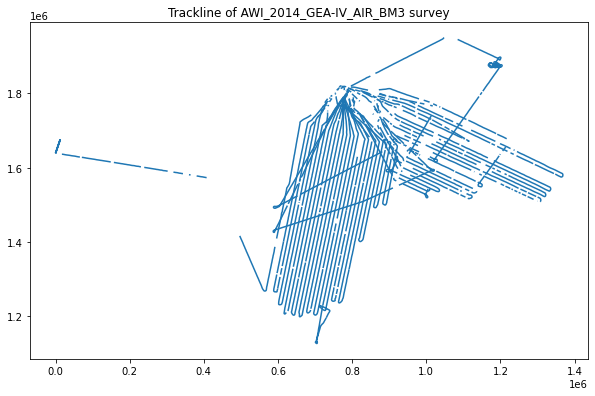

<Figure size 2000x2000 with 0 Axes>

In [14]:
plt.rcParams['figure.figsize'] = [10,10] # Set the size of the inline plot


fig, ax = plt.subplots(1, 1)
fig=plt.figure(figsize=(20,20), dpi= 100, facecolor='w', edgecolor='k')
gdf.plot(ax=ax)
ax.set_title('Trackline of %s survey' %ID)

### Results

All the BEDMAP lines shapefiles are available online: 
 
* BEDMAP2 shapeLines:
* BEDMAP3 shapeLines:

Please note that the lines are not available for BEDMAP1 as it was difficult to separate each survey into one campaign file.